# A notebook to demonstrate a typical PyTorch Workflow

# DATA

In [35]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cpu


In [59]:
weight = 0.7
bias = 0.3

X = torch.arange(0 , 1  , 0.02).unsqueeze(dim=1)
y = X*weight + bias

In [60]:
len(X) , len(y)

(50, 50)

In [61]:
X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [62]:
train_split = int(0.8 *len(X))

X_train , y_train = X[:train_split] , y[:train_split]
X_test , y_test = X[train_split:] , y[train_split:]

len(X_train) , len(y_train) , len(X_test) , len(y_test)

(40, 40, 10, 10)

In [63]:
def plot_predictions(train_data = X_train ,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data , train_labels , c='b' , s=4, label = "Training Data")
  plt.scatter(test_data , test_labels , c='g' , s=4 ,label = "Testing Data")
  if predictions is not None:
    plt.scatter(test_data , predictions , s=4 ,c='r' ,label = "Predictions")
  plt.legend(prop = { "size": 14})

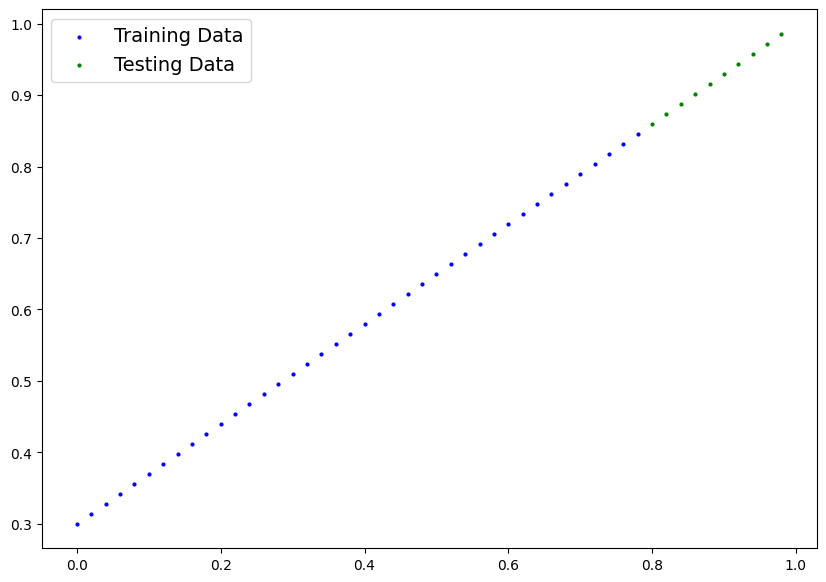

In [64]:
plot_predictions()

# BUILD MODEL


In [65]:
class LinearRegressionModelV2(nn.Module):

  def __init__(self):
    super().__init__()

    self.linear_layer = nn.Linear(in_features = 1 ,
                                  out_features = 1)

  def forward(self , x : torch.Tensor) ->torch.Tensor:
    return self.linear_layer(x)

In [96]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()

model_1

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [97]:
model_1.parameters()

<generator object Module.parameters at 0x7b10a5daeff0>

In [98]:
list(model_1.parameters()) , model_1.state_dict()

([Parameter containing:
  tensor([[0.7645]], requires_grad=True),
  Parameter containing:
  tensor([0.8300], requires_grad=True)],
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [99]:
next(model_1.parameters()).device

device(type='cpu')

In [100]:
model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [101]:
next(model_1.parameters()).device

device(type='cpu')

# TRAINING

In [102]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [103]:
epochs = 200

X_train.to(device)
y_train.to(device)
X_test.to(device)
y_test.to(device)

epochs_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_1.train()

  y_pred = model_1(X_train)

  loss = loss_fn(y_pred , y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred , y_test)

  if epoch % 10 ==0:
    epochs_count.append(epoch)
    loss_values.append(loss.detach().cpu().numpy())
    test_loss_values.append(test_loss.detach().cpu().numpy())

    print(f"Epoch : {epoch} ,  Loss : {loss} , Test Loss : {test_loss}")
    print(model_1.state_dict())


Epoch : 0 ,  Loss : 0.5551779866218567 , Test Loss : 0.5739762187004089
OrderedDict([('linear_layer.weight', tensor([[0.7606]])), ('linear_layer.bias', tensor([0.8200]))])
Epoch : 10 ,  Loss : 0.4399680495262146 , Test Loss : 0.4392663538455963
OrderedDict([('linear_layer.weight', tensor([[0.7216]])), ('linear_layer.bias', tensor([0.7200]))])
Epoch : 20 ,  Loss : 0.3247582018375397 , Test Loss : 0.30455657839775085
OrderedDict([('linear_layer.weight', tensor([[0.6826]])), ('linear_layer.bias', tensor([0.6200]))])
Epoch : 30 ,  Loss : 0.20954827964305878 , Test Loss : 0.16984674334526062
OrderedDict([('linear_layer.weight', tensor([[0.6436]])), ('linear_layer.bias', tensor([0.5200]))])
Epoch : 40 ,  Loss : 0.09433844685554504 , Test Loss : 0.03513689711689949
OrderedDict([('linear_layer.weight', tensor([[0.6046]])), ('linear_layer.bias', tensor([0.4200]))])
Epoch : 50 ,  Loss : 0.023886386305093765 , Test Loss : 0.04784906655550003
OrderedDict([('linear_layer.weight', tensor([[0.5872]])

In [104]:
model_1.eval()
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

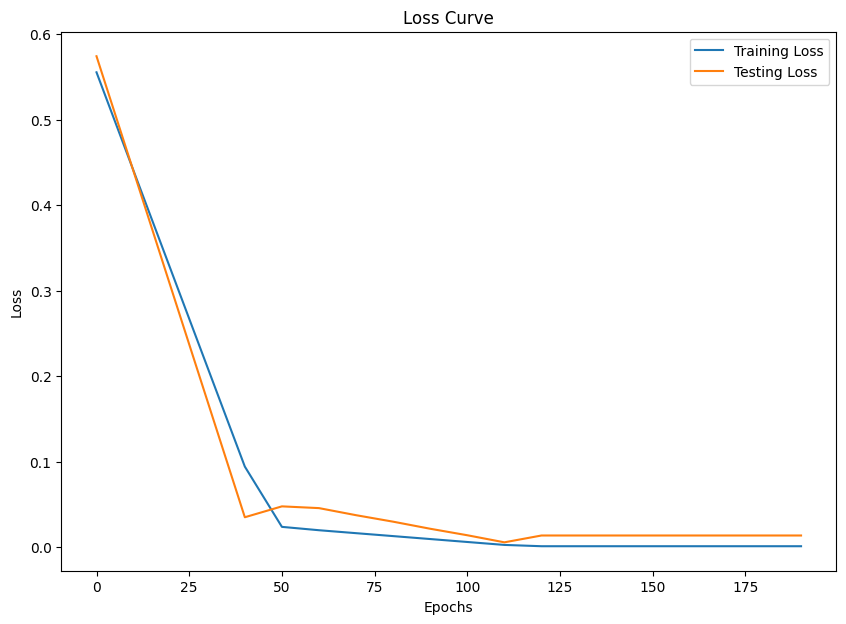

In [105]:
plt.figure(figsize = (10  , 7))
plt.plot(epochs_count , loss_values , label = "Training Loss")
plt.plot(epochs_count , test_loss_values , label = "Testing Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

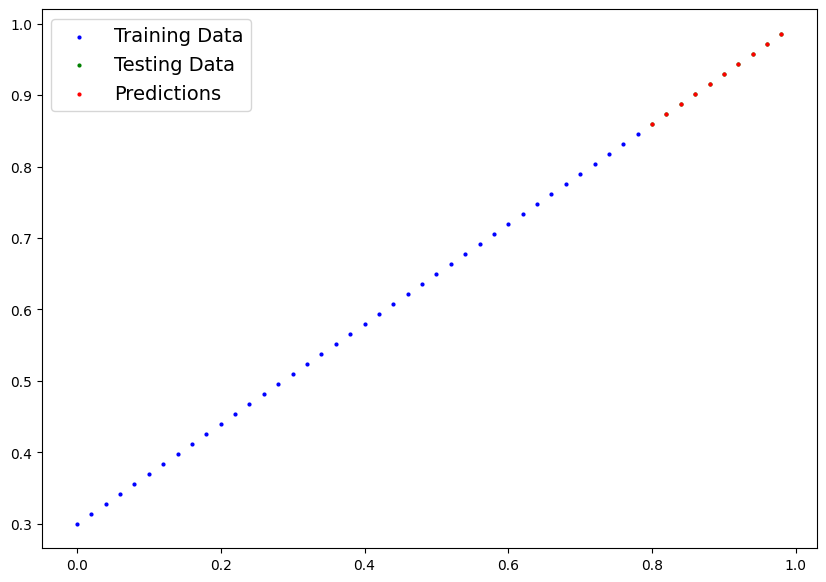

In [106]:
plot_predictions(predictions = y_preds)

# SAVE AND LOAD MODEL

In [85]:
from pathlib import Path


MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True , exist_ok = True)
MODEL_NAME = "model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/model_1.pth')

In [87]:
torch.save(obj = model_1.state_dict(),
           f = MODEL_SAVE_PATH)

In [88]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [89]:
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [91]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_y_preds = loaded_model_1(X_test)

loaded_y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

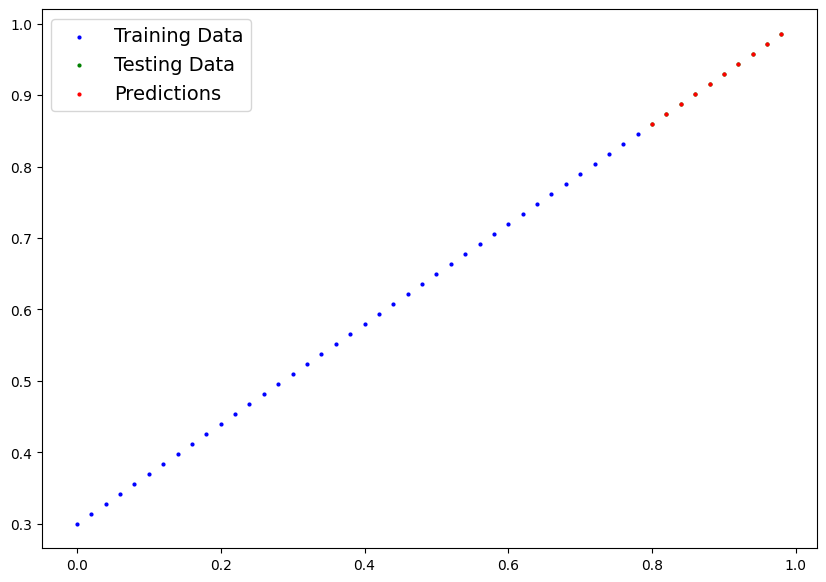

In [92]:
plot_predictions(predictions = loaded_y_preds)